# Classification of covid-19 images using CNN with transfer learning
---

It contains around 251 Chest X-ray cleaned images of for training and 317 in total, 3 classes: Covid, normal and with Viral Pneumonia

## Pre-processing

Split the training data into training and validation

In [16]:
from sklearn.datasets import load_files
from keras.preprocessing import image
from keras.utils import np_utils
import numpy as np
import os
import shutil
import re

train_path = 'Covid19-dataset/train'
test_path = 'Covid19-dataset/test'
valid_path = 'Covid19-dataset/valid'

#load dataset. Paths and targets
train_data = load_files(train_path)    #dict with keys 'data', 'filenames', 'target', 'target_names'. Shuffle = True
train_filenames = np.array(data['filenames']) #251 images in total: 111 with Covid, 70 normal, 70 with pneumonia
train_targets = np_utils.to_categorical(np.array(data['target']))

#create validation path
for i in data['target_names']:
    dir = 'Covid19-dataset/valid/' + i
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)

#Split filenames (80/20)
(train_filenames, valid_filenames) = train_filenames[50:], train_filenames[:50]

#Move validation files to validation folder
for name in valid_filenames:
    shutil.move(name, name.replace('train', 'valid'))

As we do not have much data, we can load the images directly into memory and convert them to tensors

In [109]:
from sklearn.datasets import load_files
from keras.preprocessing import image
from keras.utils import np_utils
import numpy as np
import os
import shutil
import re


train_path = 'Covid19-dataset/train'
test_path = 'Covid19-dataset/test'

def load_data(dir_path):
    '''
    Returns filenames and categorically-processed targets for a given directory
    '''
    data = load_files(dir_path)    #dict with keys 'data', 'filenames', 'target', 'target_names'. Shuffle = True
    filenames = np.array(data['filenames']) #251 images in total: 111 with Covid, 70 normal, 70 with pneumonia
    targets = np_utils.to_categorical(np.array(data['target']))
    target_names = data['target_names']
    return filenames, targets, target_names

train_filenames, y_train, target_names = load_data(train_path)
test_filenames, y_test, target_names = load_data(test_path)

Image sizes vary greatly. We convert them to numpy tensors with a size (224, 224)

In [57]:
def from_path_to_tensor(img_path):
    '''
    Read path of images and convert them to numpy arrays
    '''
    img = image.load_img(img_path, target_size=(224, 224))
    arr_im = image.img_to_array(img)
    return np.expand_dims(arr_im, axis=0)

x_train = np.vstack([from_path_to_tensor(im_path) for im_path in train_filenames])
x_test = np.vstack([from_path_to_tensor(im_path) for im_path in test_filenames])

In [168]:
x_train.shape

(251, 224, 224, 3)

In [169]:
x_test.shape

(66, 224, 224, 3)

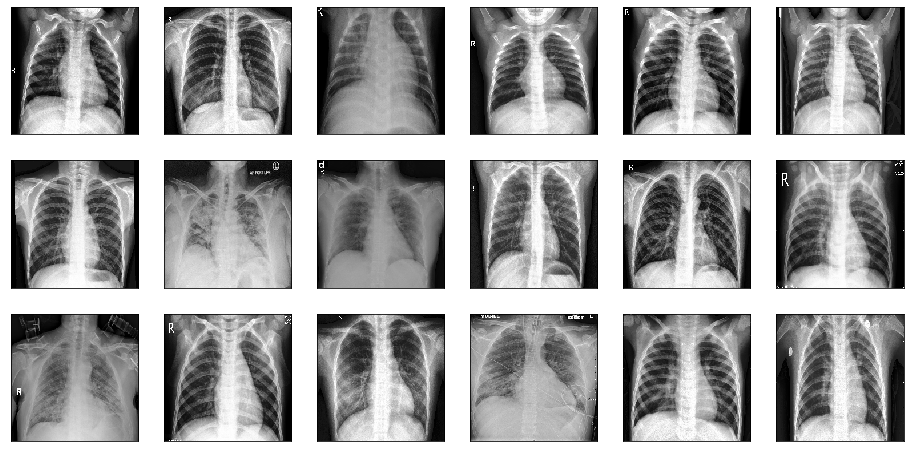

In [58]:
#show the data
import numpy as np
import matplotlib.pyplot as plt
fig= plt.figure(figsize = (16,8))
for i in np.arange(18):
    ax = fig.add_subplot(3, 6, i+1, xticks=[], yticks = [])
    ax.imshow(x_train[i].astype('uint8'))

Normalization to help gradient descent to converge.

In [59]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#mean over all axes, i.e., of the entire 3D tensor
mean = np.mean(x_train) 
std = np.std(x_train)

#normalization. Factor 1e-7 added to avoid division by zero if std = 0
x_train = (x_train - mean) / (std + 1e-7)  
x_test = (x_test - mean) / (std + 1e-7) 

There are about 60% more samples with Covid than Normal or with Pneumonia. Is accuracy the best metric for evaluating the model?
- We might be more interested in catching the Covid cases, in this case minimizing the false negatives, i.e., maximizing Recall.
- We start with accuracy, but in the last part of the project we'll create a confusion matrix

We set an image size of (224, 224).
Generate batches of tensor image data with data augmentation

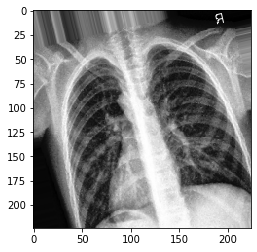

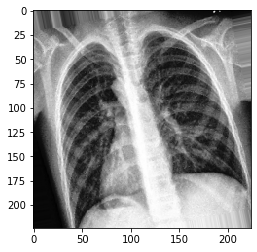

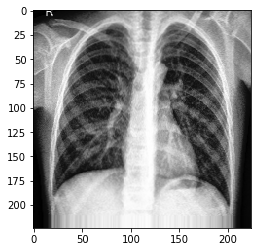

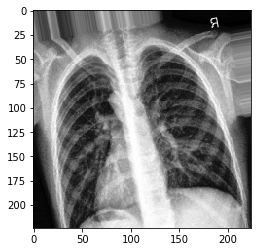

In [60]:
from keras.preprocessing.image import ImageDataGenerator
# create instance of class ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 15,
                             width_shift_range = 15,
                             height_shift_range = 0.1,
                             horizontal_flip = True)

datagen.fit(x_train)

# show the effect of data augmentation on one image as an example
i=0
x = x_train[10].reshape( (1,) + x_train[10].shape)

for batch in datagen.flow(x, batch_size =1):
    plt.figure(i)
    plt.imshow(image.array_to_img(batch[0]))
    i+=1
    if i % 4 == 0:
        break
plt.show()


# Do we need RGB or change to grayscale to speed up the process?

## Designing the model

We will use transfer learning, given our small dataset.
- VGGNet: all conv. layers are 3x3 kernel-sized filters with strides =1 and padding = same. Pooling lay. are 2x2 and strides =2. ReLU activation functions. We will use configuration "D", e.g. VGG16, 16 weights layers. 
- VGGNet trained on "imagenet", dataset used to benchmark classification algos
- Given that dataset is small, and not similar to 'Imagenet' sample, we will use fine-tuning.

In [61]:
from keras.applications import vgg16
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback

def build_model():
        
    #global avg pooling to the output of the last conv.layer
    conv_base = vgg16.VGG16(weights = 'imagenet', include_top= False, input_shape = (224, 224, 3), pooling = 'avg')

    #Train 1/3 of the conv.layers, i.e., ~4 last, and freeze the initial ones with more general patterns learned
    for layer in conv_base.layers[:-4]:
        layer.trainable = False

    #add the classifier layers
    last_output = conv_base.output

    x = Dropout(0.5)(last_output)
    x = Dense(3, activation='softmax', name = 'softmax')(x)

    model = Model(inputs=conv_base.input, outputs=x)

    model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [51]:
build_model().summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

As we have so few images, splitting the training data into "training" and "validation" will cause the validation set to have extremely few samples. 
This will iimply that the validation scores will change a lot depending on our splitting criterium, which will prevent us from evaluating the model correctly.

To overcome this situation, we use:
### K-fold cross validation

In [62]:
k = 3
num_val_samples = x_train.shape[0] // k
num_epochs = 35
all_acc_scores = []
all_loss_scores = []

for i in range(k):
    print('processing fold #', i)
    x_val = x_train[i * num_val_samples: (i+1)*num_val_samples]
    y_val = y_train[i * num_val_samples: (i+1)*num_val_samples]

    x_partial_train = np.concatenate(
        [x_train[:i*num_val_samples], 
         x_train[(i+1)*num_val_samples:]], 
        axis = 0
    )
    
    y_partial_train = np.concatenate(
        [y_train[:i*num_val_samples], 
         y_train[(i+1)*num_val_samples:]], 
        axis = 0
    ) 
    
    model = build_model()
    
        
    checkpointer = ModelCheckpoint(filepath='covid.model.hdf5', save_best_only=True, verbose = 1)
    #early_stop = EarlyStopping(monitor='val_loss', patience=20)
    lambda_call= LambdaCallback(on_batch_end=lambda batch,logs:print(logs))
    
    partial_train_generator = datagen.flow(x_partial_train, y_partial_train, batch_size = num_val_samples) 

    history = model.fit(partial_train_generator, validation_data = (x_val, y_val), steps_per_epoch = x_partial_train.shape[0] // num_val_samples,\
    epochs=num_epochs, verbose=1, callbacks=[checkpointer, lambda_call])

    all_acc_scores.append(history.history['accuracy'])
    all_loss_scores.append(history.history['val_loss'])



processing fold # 0
Epoch 1/35
2/2 [==============================] - 27s 25s/step - loss: 1.5733 - accuracy: 0.3294 - val_loss: 1.1056 - val_accuracy: 0.3614

Epoch 00001: val_loss improved from inf to 1.10563, saving model to covid.model.hdf5
Epoch 2/35
2/2 [==============================] - 59s 44s/step - loss: 1.4614 - accuracy: 0.2831 - val_loss: 1.0507 - val_accuracy: 0.4337

Epoch 00002: val_loss improved from 1.10563 to 1.05070, saving model to covid.model.hdf5
Epoch 3/35
2/2 [==============================] - 29s 28s/step - loss: 1.2432 - accuracy: 0.4824 - val_loss: 0.9738 - val_accuracy: 0.4337

Epoch 00003: val_loss improved from 1.05070 to 0.97377, saving model to covid.model.hdf5
Epoch 4/35
2/2 [==============================] - 47s 31s/step - loss: 1.1558 - accuracy: 0.4759 - val_loss: 0.9045 - val_accuracy: 0.4578

Epoch 00004: val_loss improved from 0.97377 to 0.90453, saving model to covid.model.hdf5
Epoch 5/35
2/2 [==============================] - 30s 30s/step - los

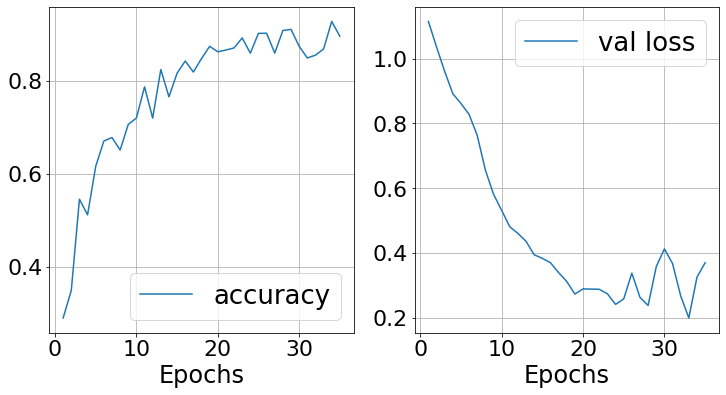

In [65]:
#Plot the average accuracy of the batches per epoch ()
average_acc_history =[ np.mean( [ x[i] for x in all_acc_scores] ) for i in range(35) ]
average_loss_history =[ np.mean( [ x[i] for x in all_loss_scores] ) for i in range(35) ]

import matplotlib.pyplot as plt
fig, (ax,ax2) = plt.subplots(1,2, figsize = (12,6))

ax.plot(range(1, len(average_acc_history) + 1), average_acc_history, label= 'accuracy')
ax.set_xlabel('Epochs', fontsize = 24)

ax2.plot(range(1, len(average_loss_history) + 1), average_loss_history, label= 'val loss')
ax2.set_xlabel('Epochs', fontsize = 24)
ax.legend(fontsize = 26)
ax2.legend(fontsize = 26)
ax.grid(True)
ax2.grid(True)
ax2.tick_params(labelsize=22)
ax.tick_params(labelsize=22)

plt.show()



In [76]:
print('epoch with minimum validation loss:  %s'% (np.array(average_loss_history).argmin() +1))

epoch with minimum validation loss:  33


This network seems to be doing a good job. loss is consistently decreasing until epoch 24. Then it wobbles and finds a  minmum at epoch 33. We will now train this network again (with the same hyperparameters) on all the training data for 33 epochs

In [67]:
final_model = build_model()
    
batch_size = 64
num_epochs = 33

train_generator = datagen.flow(x_train, y_train, batch_size = batch_size) 

history = final_model.fit(train_generator, steps_per_epoch = x_train.shape[0] // batch_size,\
    epochs=num_epochs, verbose=1)


Epoch 1/33
3/3 [==============================] - 28s 10s/step - loss: 1.2384 - accuracy: 0.4064
Epoch 2/33
3/3 [==============================] - 29s 10s/step - loss: 1.0692 - accuracy: 0.5401
Epoch 3/33
3/3 [==============================] - 29s 10s/step - loss: 0.8229 - accuracy: 0.6471
Epoch 4/33
3/3 [==============================] - 28s 9s/step - loss: 0.7050 - accuracy: 0.6684
Epoch 5/33
3/3 [==============================] - 28s 9s/step - loss: 0.4884 - accuracy: 0.8021
Epoch 6/33
3/3 [==============================] - 28s 9s/step - loss: 0.4388 - accuracy: 0.8333
Epoch 7/33
3/3 [==============================] - 27s 9s/step - loss: 0.3333 - accuracy: 0.8556
Epoch 8/33
3/3 [==============================] - 27s 9s/step - loss: 0.3474 - accuracy: 0.8542
Epoch 9/33
3/3 [==============================] - 27s 9s/step - loss: 0.2907 - accuracy: 0.8930
Epoch 10/33
3/3 [==============================] - 29s 9s/step - loss: 0.2563 - accuracy: 0.9091
Epoch 11/33
3/3 [===================

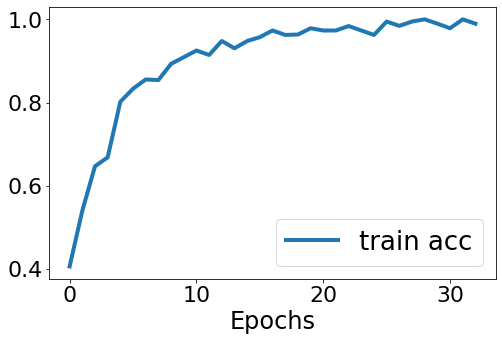

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( figsize = (8,5))
ax.plot(history.history['accuracy'], label= 'train acc', linewidth = 4)
ax.legend(fontsize = 26)
ax.tick_params(labelsize=22)
ax.set_xlabel('Epochs', fontsize = 24)


plt.show()

Try model on the test data

In [75]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*final_model.evaluate(x_test, y_test)))

3/3 [==============================] - 8s 2s/step - loss: 0.0656 - accuracy: 0.9697

Testing loss: 0.0656
Testing accuracy: 0.9697


## Model evaluation: Confusion matrix and PR curve

In [130]:
#predicted probabilities by our model for each class and x-ray image
y_prob_predic = final_model.predict(x_test)
y_classes_predic = y_prob_predic.argmax(axis=-1)

In [131]:
y_test_labels = []
y_predic_class = []
for i in y_test: 
    y_test_labels.append(target_names[np.argwhere(i)[0][0]])
    
y_predic_class = [  target_names[i]  for i in y_classes_predic]

In [134]:
import pandas as pd
df_prob = pd.DataFrame()

df_prob['Predicted prob. for '+y_names[0]] = y_prob[:,0]
df_prob['Predicted prob. for '+y_names[1]] = y_prob[:,1]
df_prob['Predicted prob. for '+y_names[2]] = y_prob[:,2]

df_prob['Predicted test class'] = y_predic_class
df_prob['Real test class'] = y_test_labels

df_prob

,Predicted prob. for Covid,Predicted prob. for Normal,Predicted prob. for Viral Pneumonia,Predicted test class,Real test class
0,0.000128,0.985677,0.014195,Normal,Normal
1,0.000051,0.998083,0.001865,Normal,Normal
2,0.000028,0.810608,0.189365,Normal,Normal
3,0.000057,0.000008,0.999935,Viral Pneumonia,Viral Pneumonia
4,0.000050,0.223540,0.776410,Viral Pneumonia,Viral Pneumonia
...,...,...,...,...,...
61,0.994823,0.000025,0.005152,Covid,Covid
62,0.999972,0.000001,0.000027,Covid,Covid
63,0.013012,0.089993,0.896995,Viral Pneumonia,Viral Pneumonia
64,0.000322,0.016633,0.983045,Viral Pneumonia,Viral Pneumonia


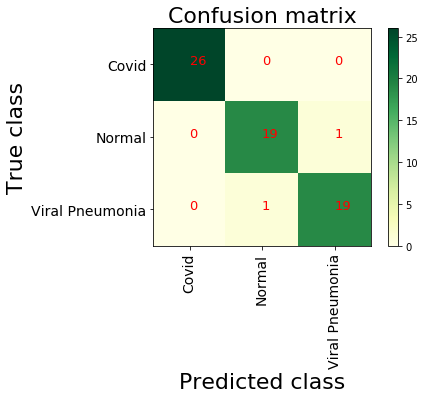

In [150]:
from sklearn.metrics import confusion_matrix

c_m = confusion_matrix(np.argmax(y_test, axis=1),
                      np.argmax(y_prob_predic, axis=1))

plt.imshow(c_m, cmap=plt.cm.YlGn)
plt.colorbar()
indexes = np.arange(len(target_names))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j], fontsize = 13, color = 'red')
plt.xticks(indexes, target_names, rotation=90, fontsize = 14)
plt.xlabel('Predicted class', fontsize = 22)
plt.yticks(indexes, target_names, fontsize = 14)
plt.ylabel('True class', fontsize = 22)
plt.title('Confusion matrix', fontsize = 22)
plt.show()

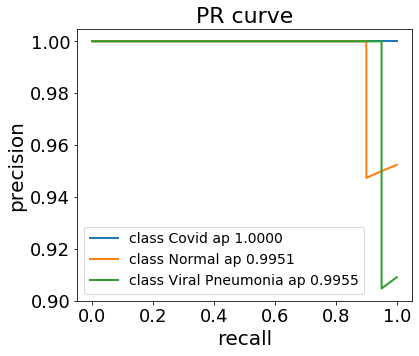

In [211]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(6,5))
# precision recall curve
precision = dict()
recall = dict()
thresholds = dict()
ap = dict() #average precision
for i in range(3):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test[:, i],
                                                        y_prob_predic[:, i])
    
    #compute the average precision (AP) by calculating the are under the PR curve (AUC)
    ap[i] = average_precision_score(y_test[:,i], y_prob_predic[:,i])
    
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(target_names[i]) + ' ap {0:0.4f}'.format(ap[i]))

    
        
plt.xlabel("recall", fontsize = 20)
plt.ylabel("precision", fontsize = 20)
plt.legend(loc="best", fontsize = 14)
plt.title("PR curve", fontsize = 22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.show()

Recall = TP / (TP + FN)

Precision = TP / (TP + FP)

As recall increases for lower thresholds (false negative cases decrease), precision decreases a bit (false positive cases increase). Even though precision is not necessarilly monotonically decreasing with the threshold, recall is in fact monotonically increasing. This is because when increasing the number of positive predictions by lowering the threshold (growing recall),  more positive (TP) than negative (FP) samples might have been added at a given step.

So when threshold decreases, TP increase, FN decrease (thus recall increases monotonically), FP increase (so, depending whether TP or FP increase more, the precision will change)

Compute the mean average PR: the average AP over all the classes

In [189]:
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_prob_predic.ravel())

ap["micro"] = average_precision_score(y_test, y_prob_predic, average="micro")

print('Average precision score, micro-averaged over all classes: {0:0.4f}'
      .format(ap["micro"]))

Average precision score, micro-averaged over all classes: 0.9982


Text(0.5, 1.0, 'mAP=0.99821')

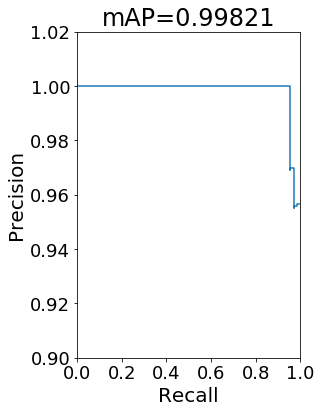

In [201]:
plt.figure(figsize=(4,6))
plt.step(recall['micro'], precision['micro'], where='post')
plt.xlabel('Recall', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.ylim([0.9, 1.02])
plt.xlim([0.0, 1.0])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.title('mAP={0:0.5f}'.format(ap["micro"]), fontsize = 24)
